In [72]:
import scipy.stats as stats
import pandas as pd
import numpy as np
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute._iterative import IterativeImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import dateutil.parser as parser
from sklearn.impute import SimpleImputer as Imputer, SimpleImputer
from sklearn.neighbors import NearestNeighbors as neigh
from sklearn.neighbors import KNeighborsRegressor as neigh
from sklearn.model_selection import train_test_split as split
from sklearn import metrics
from math import sqrt
import json
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from missingpy import KNNImputer, MissForest
import copy



In [81]:
data = pd.read_csv("../data/other_train.csv",index_col=0)

dict_array = []
string = '{"mean_glucose": 9999999,"std_glucose": 9999999,"kurtosis_glucose":9999999,"skewness_glucose":9999999,"mean_oxygen":9999999,"std_oxygen":9999999,"kurtosis_oxygen":9999999,"skewness_oxygen":9999999}'
data.medical_info.apply(lambda x: dict_array.append(json.loads(x.replace("'","\"").replace(":\"",":").replace("\",",",").replace("\"}","}") if isinstance(x,str) else string)))
medical_datas = pd.DataFrame(dict_array)

for item in medical_datas:
    data[item] = medical_datas[item].astype(float)
data = data.drop(columns=['medical_info'])
# print(data)
# data.info()

person = pd.read_csv("../data/personal_train.csv",index_col=0)
# print(person)
# person.info()

In [82]:

data = data.replace({ 9999999 : np.nan },regex=False)
data = data.replace({'^[? ]*$' : np.nan},regex=True)
person = person.replace({'^[? ]*$' : np.nan},regex=True)
og = copy.deepcopy(data) 

In [4]:
numeric = data.select_dtypes(include=['float64'])
categoric = data.select_dtypes(include=['object'])
numeric['name'] = categoric['name']

numeric = numeric.groupby('name').aggregate('mean')
categoric = categoric.groupby('name').aggregate('first')

data = categoric.merge(numeric, on=['name'])

C:\Users\Lukas\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
merged_data = pd.merge(person, data, on=['name','address'], how='left')


In [6]:
merged_data = merged_data.replace(['FALSE','F'],'f',regex=True)
merged_data = merged_data.replace(['TRUE','T'],'t',regex=True)

merged_data = merged_data.replace([' <=50K'],'<=50K',regex=True)
merged_data = merged_data.replace([' >50K'],'>50K',regex=True)


merged_data = merged_data.replace([' Other-relative'],' Other_relative',regex=True)
merged_data = merged_data.replace([' Not-in-family'],' Not_in_family',regex=True)
merged_data = merged_data.replace([' Own-child'],' Own_child',regex=True)


for i, row in merged_data.iterrows():
        
    date = parser.parse(merged_data.iloc[i]['date_of_birth'].split(' ')[0])
    day = date.day
    month = date.month
    year = date.year
    
    if (year > 2019):
        year = year - 100

    merged_data.at[i,'date_of_birth'] = str(day) + "/" + str(month) + "/" + str(year)
            
    if ((pd.isna(row['age'])) | (row['age'] > 115) | (row['age'] < 0)):
        merged_data.at[i,'age'] = 2019 - year

merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3932
Data columns (total 28 columns):
name                3933 non-null object
address             3933 non-null object
age                 3933 non-null float64
sex                 3933 non-null object
date_of_birth       3933 non-null object
race                3933 non-null object
marital-status      3933 non-null object
occupation          3703 non-null object
pregnant            3931 non-null object
relationship        3932 non-null object
education           3933 non-null object
income              3932 non-null object
native-country      3872 non-null object
workclass           3341 non-null object
education-num       3933 non-null float64
capital-gain        3933 non-null float64
fnlwgt              3932 non-null float64
class               3933 non-null float64
hours-per-week      3932 non-null float64
capital-loss        3933 non-null float64
mean_glucose        3932 non-null float64
std_glucose         3932

In [7]:
# Remove outliers which can be probably not use
# print(merged_data['education-num'].value_counts())
# sns.distplot(merged_data['education-num'])

# ## Remove outliers from education-num
# # sns.boxplot(merged_data['education-num'])
# merged_data.loc[merged_data['education-num'] < 5,'education-num'] = np.NaN
# # sns.boxplot(merged_data['education-num'])
# 
# ## Remove outliers from 'capital-gain'
# # sns.boxplot(merged_data['capital-gain'])
# merged_data.loc[merged_data['capital-gain'] > 30000,'capital-gain'] = np.NaN
# # sns.boxplot(merged_data['capital-gain'])
# 
# ## Remove outliers from 'fnlwgt'
# # sns.boxplot(merged_data['fnlwgt'])
# merged_data.loc[merged_data['fnlwgt'] > 800000,'fnlwgt'] = np.NaN
# # sns.boxplot(merged_data['fnlwgt'])
# 
# ## Remove outliers from 'hours-per-week'
# # sns.boxplot(merged_data['hours-per-week'])
# merged_data.loc[(merged_data['hours-per-week'] > 57) | (merged_data['hours-per-week'] < 8),'hours-per-week'] = np.NaN
# # sns.boxplot(merged_data['hours-per-week'])

In [8]:
# Remove outliers on floats datas

## Remove outliers from 'kurtosis_glucose'
column = 'kurtosis_glucose'
# sns.boxplot(merged_data[column])
# merged_data[column].hist()
mask = (merged_data[column] > 6) | (merged_data[column] < -1)
merged_data.loc[mask ,column] = np.NaN

## Remove outliers from 'mean_glucose'
column = 'mean_glucose'
# sns.boxplot(merged_data[column])
# merged_data[column].hist()
mask = (merged_data[column] > 150)  
merged_data.loc[mask ,column] = np.NaN

## Remove outliers from 'mean_oxygen'
column = 'mean_oxygen'
# sns.boxplot(merged_data[column])
# merged_data[column].hist()
mask = (merged_data[column] > 120)  
merged_data.loc[mask ,column] = np.NaN

## Remove outliers from 'kurtosis_oxygen'
column = 'kurtosis_oxygen'
# sns.boxplot(merged_data[column])
# merged_data[column].hist()
mask = (merged_data[column] > 20)  
merged_data.loc[mask ,column] = np.NaN

## Remove outliers from 'skewness_glucose'
column = 'skewness_glucose'
# sns.boxplot(merged_data[column])
# merged_data[column].hist()
mask = (merged_data[column] > 40)  
merged_data.loc[mask ,column] = np.NaN

## Remove outliers from 'skewness_oxygen'
column = 'skewness_oxygen'
# sns.boxplot(merged_data[column])
# merged_data[column].hist()
mask = (merged_data[column] > 350)  
merged_data.loc[mask ,column] = np.NaN

## Remove outliers from 'std_glucose'
column = 'std_glucose'
# sns.boxplot(merged_data[column])
# merged_data[column].hist()
mask = (merged_data[column] > 62) 
merged_data.loc[mask ,column] = np.NaN

## Remove outliers from 'std_oxygen'
column = 'std_oxygen'
# sns.boxplot(merged_data[column])
# merged_data[column].hist()
mask = (merged_data[column] > 80)  
merged_data.loc[mask ,column] = np.NaN


In [9]:
# Divide datas into 3 category

old = merged_data
merged_data = merged_data.drop(columns=['class'])

numeric = merged_data.select_dtypes(include=['float64'])
numeric1 = numeric.iloc[:,:7].columns
print(numeric1)
numeric2 = numeric.iloc[:,7:].columns
print(numeric2)        
categoric = merged_data.select_dtypes(include=['object']).columns
print(categoric)

Index(['age', 'education-num', 'capital-gain', 'fnlwgt', 'hours-per-week',
       'capital-loss', 'mean_glucose'],
      dtype='object')
Index(['std_glucose', 'kurtosis_glucose', 'skewness_glucose', 'mean_oxygen',
       'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen'],
      dtype='object')
Index(['name', 'address', 'sex', 'date_of_birth', 'race', 'marital-status',
       'occupation', 'pregnant', 'relationship', 'education', 'income',
       'native-country', 'workclass'],
      dtype='object')


In [10]:
# Apply pipeline in category 

numeric_transformer1 = Pipeline(steps=[('imputer',MissForest(missing_values=np.NaN, max_iter=10, # Nahradenie nulovych hodnot pomocou MissForest
                                                             decreasing=False, copy=False)), 
                                      ('powerTransformer',PowerTransformer(method='yeo-johnson',
                                                                           copy=False)) # Transformuje dat aby boli viac z Gaussoveho rozdelenia
                                       ])
numeric_transformer2 = Pipeline(steps=[('imputer',KNNImputer(missing_values=np.NaN, n_neighbors=5, # Nahradenie nulovych hodnot pomocou KNN
                                                              weights='distance')), 
                                     # ('RobustScaler',StandardScaler())    # 
                                       ])
categoric_transormer = Pipeline(steps=[('imputer',SimpleImputer(strategy='most_frequent'))]) # Nahradenie nulovych hodnot pomocou najcastejsich hodnot
                                      # ('onehot',OneHotEncoder(handle_unknown='ignore'))])
preproccesors = ColumnTransformer(transformers=[('Cat', categoric_transormer, categoric),
                                                ('Num1', numeric_transformer1, numeric1),
                                                ('Num2', numeric_transformer2, numeric2)
                                                ])


In [11]:
# Execute pipeline steps

pipeline = Pipeline(steps=[('preproccesors', preproccesors)])
pipeline_datas = pipeline.fit_transform(merged_data)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


C:\Users\Lukas\Anaconda3\lib\site-packages\missingpy\knnimpute.py:224: UserWarning: There are rows with more than 50.0% missing values. These rows are not included as donor neighbors.
  .format(self.row_max_missing * 100))
C:\Users\Lukas\Anaconda3\lib\site-packages\missingpy\knnimpute.py:282: UserWarning: There are rows with more than 50.0% missing values. The missing features in these rows are imputed with column means.
  .format(self.row_max_missing * 100))
C:\Users\Lukas\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
C:\Users\Lukas\Anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
C:\Users\Lukas\Anaconda3\lib\site-packages\missing

In [12]:
# Show mereged datas

merged_data = pd.DataFrame(pipeline_datas,columns=merged_data.columns)
print(merged_data)


                     name                                            address  \
0         Roscoe Bohannon  7183 Osborne Ways Apt. 651\r\nEast Andrew, OH ...   
1            Ernest Kline  391 Ball Road Suite 961\r\nflowersborough, IN ...   
2         Harold Hendriks     8702 Vincent Square\r\nNew Jerryfurt, CO 30614   
3          Randy Baptiste     2751 Harris Crossroad\r\nWest Ashley, CA 30311   
4         Anthony Colucci  904 Robert Cliffs Suite 186\r\nWest Kyle, CO 7...   
...                   ...                                                ...   
3928      Clair Pinkleton             8582 Lee Roads\r\nCostaburgh, SC 21897   
3929         William Pope  68430 Erik terrace Suite 279\r\nPort Adamborou...   
3930         Jared Kinsey                 Unit 8416 Box 3801\r\nDPO AE 31166   
3931     frederick Lawley   34420 Brian Stream\r\nLake Michaeltown, MS 01832   
3932  Adalberto Daughters                 Unit 7931 Box 0601\r\nDPO AE 50505   

          age         sex        date_o

In [44]:
# merged_data['age'] = merged_data['age'].astype(np.float64)
merged_data['education-num'] = merged_data['education-num'].astype(np.float64)
merged_data['capital-gain'] = merged_data['capital-gain'].astype(np.float64)
merged_data['fnlwgt'] = merged_data['fnlwgt'].astype(np.float64)
# merged_data['class'] = merged_data['class'].astype(np.float64)
merged_data['hours-per-week'] = merged_data['hours-per-week'].astype(np.float64)
merged_data['capital-loss'] = merged_data['capital-loss'].astype(np.float64)
merged_data['mean_glucose'] = merged_data['mean_glucose'].astype(np.float64)
merged_data['std_glucose'] = merged_data['std_glucose'].astype(np.float64)
merged_data['kurtosis_glucose'] = merged_data['kurtosis_glucose'].astype(np.float64)
merged_data['skewness_glucose'] = merged_data['skewness_glucose'].astype(np.float64)
merged_data['mean_oxygen'] = merged_data['mean_oxygen'].astype(np.float64)
merged_data['std_oxygen'] = merged_data['std_oxygen'].astype(np.float64)
merged_data['kurtosis_oxygen'] = merged_data['kurtosis_oxygen'].astype(np.float64)
merged_data['skewness_oxygen'] = merged_data['skewness_oxygen'].astype(np.float64)
merged_data['class'] = old['class'].astype(np.int64)
print(merged_data)

                     name                                            address  \
0         Roscoe Bohannon  7183 Osborne Ways Apt. 651\r\nEast Andrew, OH ...   
1            Ernest Kline  391 Ball Road Suite 961\r\nflowersborough, IN ...   
2         Harold Hendriks     8702 Vincent Square\r\nNew Jerryfurt, CO 30614   
3          Randy Baptiste     2751 Harris Crossroad\r\nWest Ashley, CA 30311   
4         Anthony Colucci  904 Robert Cliffs Suite 186\r\nWest Kyle, CO 7...   
...                   ...                                                ...   
3928      Clair Pinkleton             8582 Lee Roads\r\nCostaburgh, SC 21897   
3929         William Pope  68430 Erik terrace Suite 279\r\nPort Adamborou...   
3930         Jared Kinsey                 Unit 8416 Box 3801\r\nDPO AE 31166   
3931     frederick Lawley   34420 Brian Stream\r\nLake Michaeltown, MS 01832   
3932  Adalberto Daughters                 Unit 7931 Box 0601\r\nDPO AE 50505   

          age         sex        date_o

In [83]:
og.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3983 entries, 0 to 3982
Data columns (total 25 columns):
name                3983 non-null object
address             3983 non-null object
race                3970 non-null object
marital-status      3965 non-null object
occupation          3731 non-null object
pregnant            3961 non-null object
education-num       3962 non-null float64
relationship        3967 non-null object
capital-gain        3970 non-null float64
education           3967 non-null object
fnlwgt              3966 non-null float64
class               3966 non-null float64
income              3965 non-null object
native-country      3905 non-null object
hours-per-week      3968 non-null float64
capital-loss        3969 non-null float64
workclass           3366 non-null object
mean_glucose        3964 non-null float64
std_glucose         3964 non-null float64
kurtosis_glucose    3964 non-null float64
skewness_glucose    3964 non-null float64
mean_oxygen         39

In [84]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3933 entries, 0 to 3932
Data columns (total 28 columns):
name                3933 non-null object
address             3933 non-null object
age                 3933 non-null object
sex                 3933 non-null object
date_of_birth       3933 non-null object
race                3933 non-null object
marital-status      3933 non-null object
occupation          3933 non-null object
pregnant            3933 non-null object
relationship        3933 non-null object
education           3933 non-null object
income              3933 non-null object
native-country      3933 non-null object
workclass           3933 non-null object
education-num       3933 non-null float64
capital-gain        3933 non-null float64
fnlwgt              3933 non-null float64
hours-per-week      3933 non-null float64
capital-loss        3933 non-null float64
mean_glucose        3933 non-null float64
std_glucose         3933 non-null float64
kurtosis_glucose    3933 

In [85]:
og.describe(include="all")

name                                          address  \
count            3983                                             3983   
unique           3933                                             3933   
top     James Menzies  455 Amber Freeway\r\nWest Timothyland, RI 32037   
freq                3                                                3   
mean              NaN                                              NaN   
std               NaN                                              NaN   
min               NaN                                              NaN   
25%               NaN                                              NaN   
50%               NaN                                              NaN   
75%               NaN                                              NaN   
max               NaN                                              NaN   

          race       marital-status     occupation pregnant  education-num  \
count     3970                 3965           3731     3961     3962.00000   
unique       5                    6             14        6            NaN   
top      White   Married-civ-spouse   Craft-repair        f            NaN   
freq      3398                 1830            547     3494            NaN   
mean       NaN                  NaN            NaN      NaN       10.05477   
std        NaN                  NaN            NaN      NaN        2.58377   
min        NaN                  NaN            NaN      NaN        1.00000   
25%        NaN                  NaN            NaN      NaN        9.00000   
50%        NaN                  NaN            NaN      NaN       10.00000   
75%        NaN                  NaN            NaN      NaN       12.00000   
max        NaN                  NaN            NaN      NaN       16.00000   

       relationship  capital-gain education  ...  capital-loss  workclass  \
count          3967   3970.000000      3967  ...   3969.000000       3366   
unique            9           NaN        16  ...           NaN          7   
top         Husband           NaN   HS-grad  ...           NaN    Private   
freq           1615           NaN      1306  ...           NaN       2518   
mean            NaN   1240.338539       NaN  ...     91.746536        NaN   
std             NaN   8300.936903       NaN  ...    412.307694        NaN   
min             NaN      0.000000       NaN  ...      0.000000        NaN   
25%             NaN      0.000000       NaN  ...      0.000000        NaN   
50%             NaN      0.000000       NaN  ...      0.000000        NaN   
75%             NaN      0.000000       NaN  ...      0.000000        NaN   
max             NaN  99999.000000       NaN  ...   2824.000000        NaN   

       mean_glucose  std_glucose  kurtosis_glucose  skewness_glucose  \
count   3964.000000  3964.000000       3964.000000       3964.000000   
unique          NaN          NaN               NaN               NaN   
top             NaN          NaN               NaN               NaN   
freq            NaN          NaN               NaN               NaN   
mean     101.296270    45.167552          0.951369          4.222697   
std       33.596246     7.608018          1.611950          9.675803   
min        6.187500    25.695250         -1.641515         -1.755332   
25%       87.720703    40.153323          0.071484         -0.120081   
50%      110.671875    45.868605          0.310578          0.375623   
75%      124.160156    50.346566          0.775953          2.083826   
max      189.734375    91.206475          8.069522         68.101622   

        mean_oxygen   std_oxygen  kurtosis_oxygen  skewness_oxygen  
count   3964.000000  3964.000000      3964.000000      3964.000000  
unique          NaN          NaN              NaN              NaN  
top             NaN          NaN              NaN              NaN  
freq            NaN          NaN              NaN              NaN  
mean      18.476218    31.163018         7.413264       

In [86]:
merged_data.describe(include="all")

name                                            address  \
count            3933                                               3933   
unique           3933                                               3933   
top     William Nance  44814 Zamora throughway\r\nEast Meganhaven, NE...   
freq                1                                                  1   
mean              NaN                                                NaN   
std               NaN                                                NaN   
min               NaN                                                NaN   
25%               NaN                                                NaN   
50%               NaN                                                NaN   
75%               NaN                                                NaN   
max               NaN                                                NaN   

          age         sex date_of_birth                 race marital-status  \
count    3933        3933          3933                 3933           3933   
unique      2        3458             5                    6             14   
top      Male  19/10/1974         White   Married-civ-spouse   Craft-repair   
freq     2664           4          3369                 1814            770   
mean      NaN         NaN           NaN                  NaN            NaN   
std       NaN         NaN           NaN                  NaN            NaN   
min       NaN         NaN           NaN                  NaN            NaN   
25%       NaN         NaN           NaN                  NaN            NaN   
50%       NaN         NaN           NaN                  NaN            NaN   
75%       NaN         NaN           NaN                  NaN            NaN   
max       NaN         NaN           NaN                  NaN            NaN   

       occupation  pregnant relationship  ...  capital-loss  mean_glucose  \
count        3933      3933         3933  ...  3.933000e+03  3.933000e+03   
unique          2         6           16  ...           NaN           NaN   
top             f   Husband      HS-grad  ...           NaN           NaN   
freq         3850      1597         1292  ...           NaN           NaN   
mean          NaN       NaN          NaN  ... -2.948880e-16  2.374009e-17   
std           NaN       NaN          NaN  ...  1.000127e+00  1.000127e+00   
min           NaN       NaN          NaN  ... -2.271658e-01 -2.048880e+00   
25%           NaN       NaN          NaN  ... -2.271658e-01 -6.281066e-01   
50%           NaN       NaN          NaN  ... -2.271658e-01  1.824724e-01   
75%           NaN       NaN          NaN  ... -2.271658e-01  7.365968e-01   
max           NaN       NaN          NaN  ...  4.402072e+00  2.006798e+00   

        std_glucose  kurtosis_glucose  skewness_glucose  mean_oxygen  \
count   3933.000000       3933.000000       3933.000000  3933.000000   
unique          NaN               NaN               NaN          NaN   
top             NaN               NaN               NaN          NaN   
freq            NaN               NaN               NaN          NaN   
mean      44.981171          0.902339          3.823568    16.150766   
std        7.238813          1.470755          8.372301    27.685820   
min       25.695250         -0.944764         -1.755332     0.213211   
25%       40.124470          0.074552         -0.119966     2.061873   
50%       45.820717          0.312617          0.373828     3.226589   
75%       50.264563          0.790273          2.081514    12.603679   
max       61.864692          5.994345         39.912909   119.732441   

         std_oxygen  kurtosis_oxygen  skewness_oxygen        class  
count   3933.000000      3933.000000      3933.000000  3933.000000  
unique          NaN              NaN              NaN          NaN  
top             NaN              NaN              NaN          NaN  
freq            NaN              NaN              NaN          NaN  
mean      30.273655 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A38B6EA4E0>]],
      dtype=object)

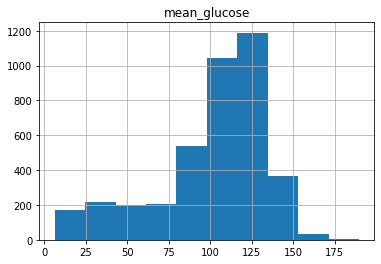

In [87]:
og.hist('mean_glucose')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A38B66DC18>]],
      dtype=object)

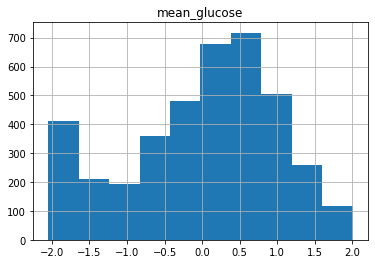

In [88]:
merged_data.hist('mean_glucose')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A38A5373C8>]],
      dtype=object)

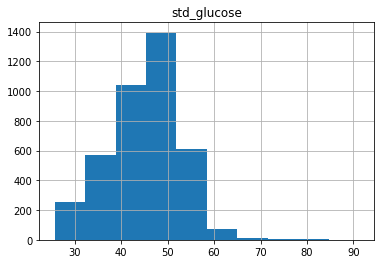

In [89]:
og.hist('std_glucose')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A3E82D7F60>]],
      dtype=object)

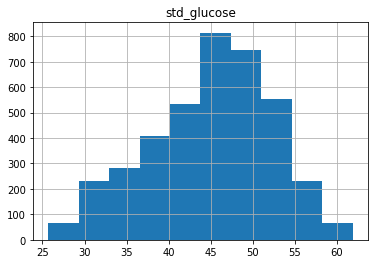

In [17]:
merged_data.hist('std_glucose')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A38B972748>]],
      dtype=object)

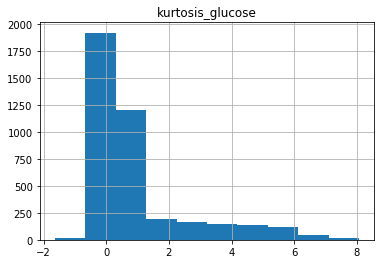

In [90]:
og.hist('kurtosis_glucose')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A3E82CE668>]],
      dtype=object)

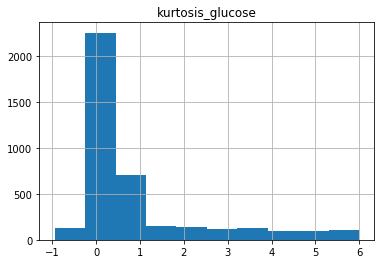

In [18]:
merged_data.hist('kurtosis_glucose')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A38A3483C8>]],
      dtype=object)

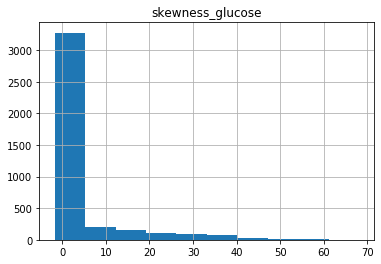

In [91]:
og.hist('skewness_glucose')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A3E839D9B0>]],
      dtype=object)

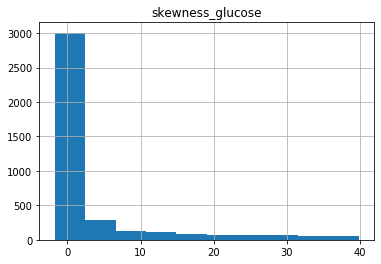

In [19]:
merged_data.hist('skewness_glucose')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A38A36B6A0>]],
      dtype=object)

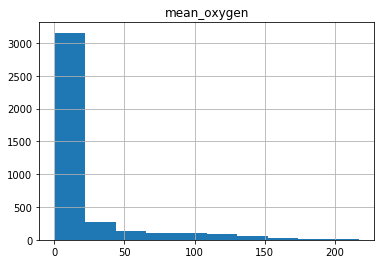

In [92]:
og.hist('mean_oxygen')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A3E83C5F28>]],
      dtype=object)

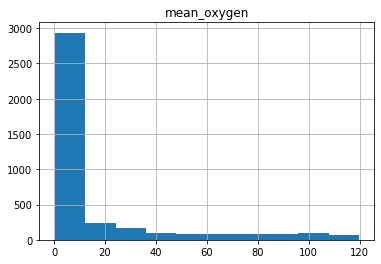

In [20]:
merged_data.hist('mean_oxygen')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A38A2B7DA0>]],
      dtype=object)

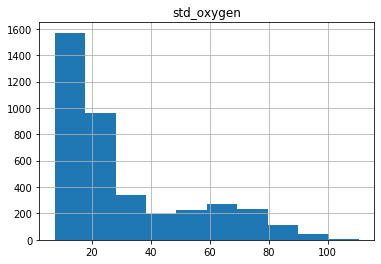

In [93]:
og.hist('std_oxygen')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A3E831AA58>]],
      dtype=object)

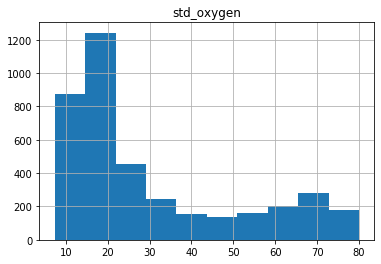

In [21]:
merged_data.hist('std_oxygen')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A38A1EF8D0>]],
      dtype=object)

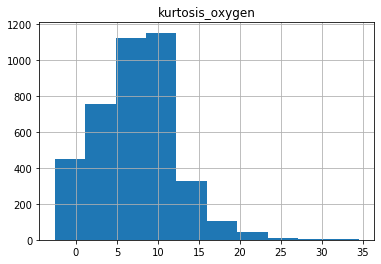

In [94]:
og.hist('kurtosis_oxygen')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A3E846EC88>]],
      dtype=object)

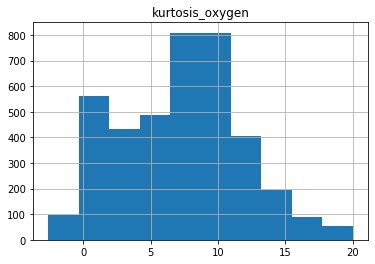

In [22]:
merged_data.hist('kurtosis_oxygen')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A38A274940>]],
      dtype=object)

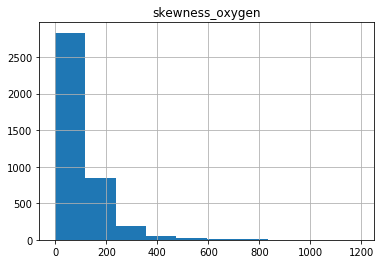

In [95]:
og.hist('skewness_oxygen')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A3E84F7780>]],
      dtype=object)

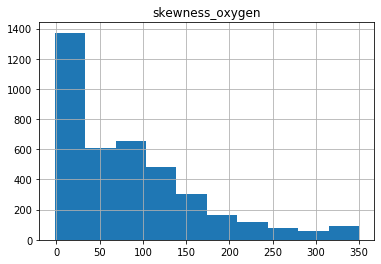

In [23]:
merged_data.hist('skewness_oxygen')

C:\Users\Lukas\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\Lukas\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


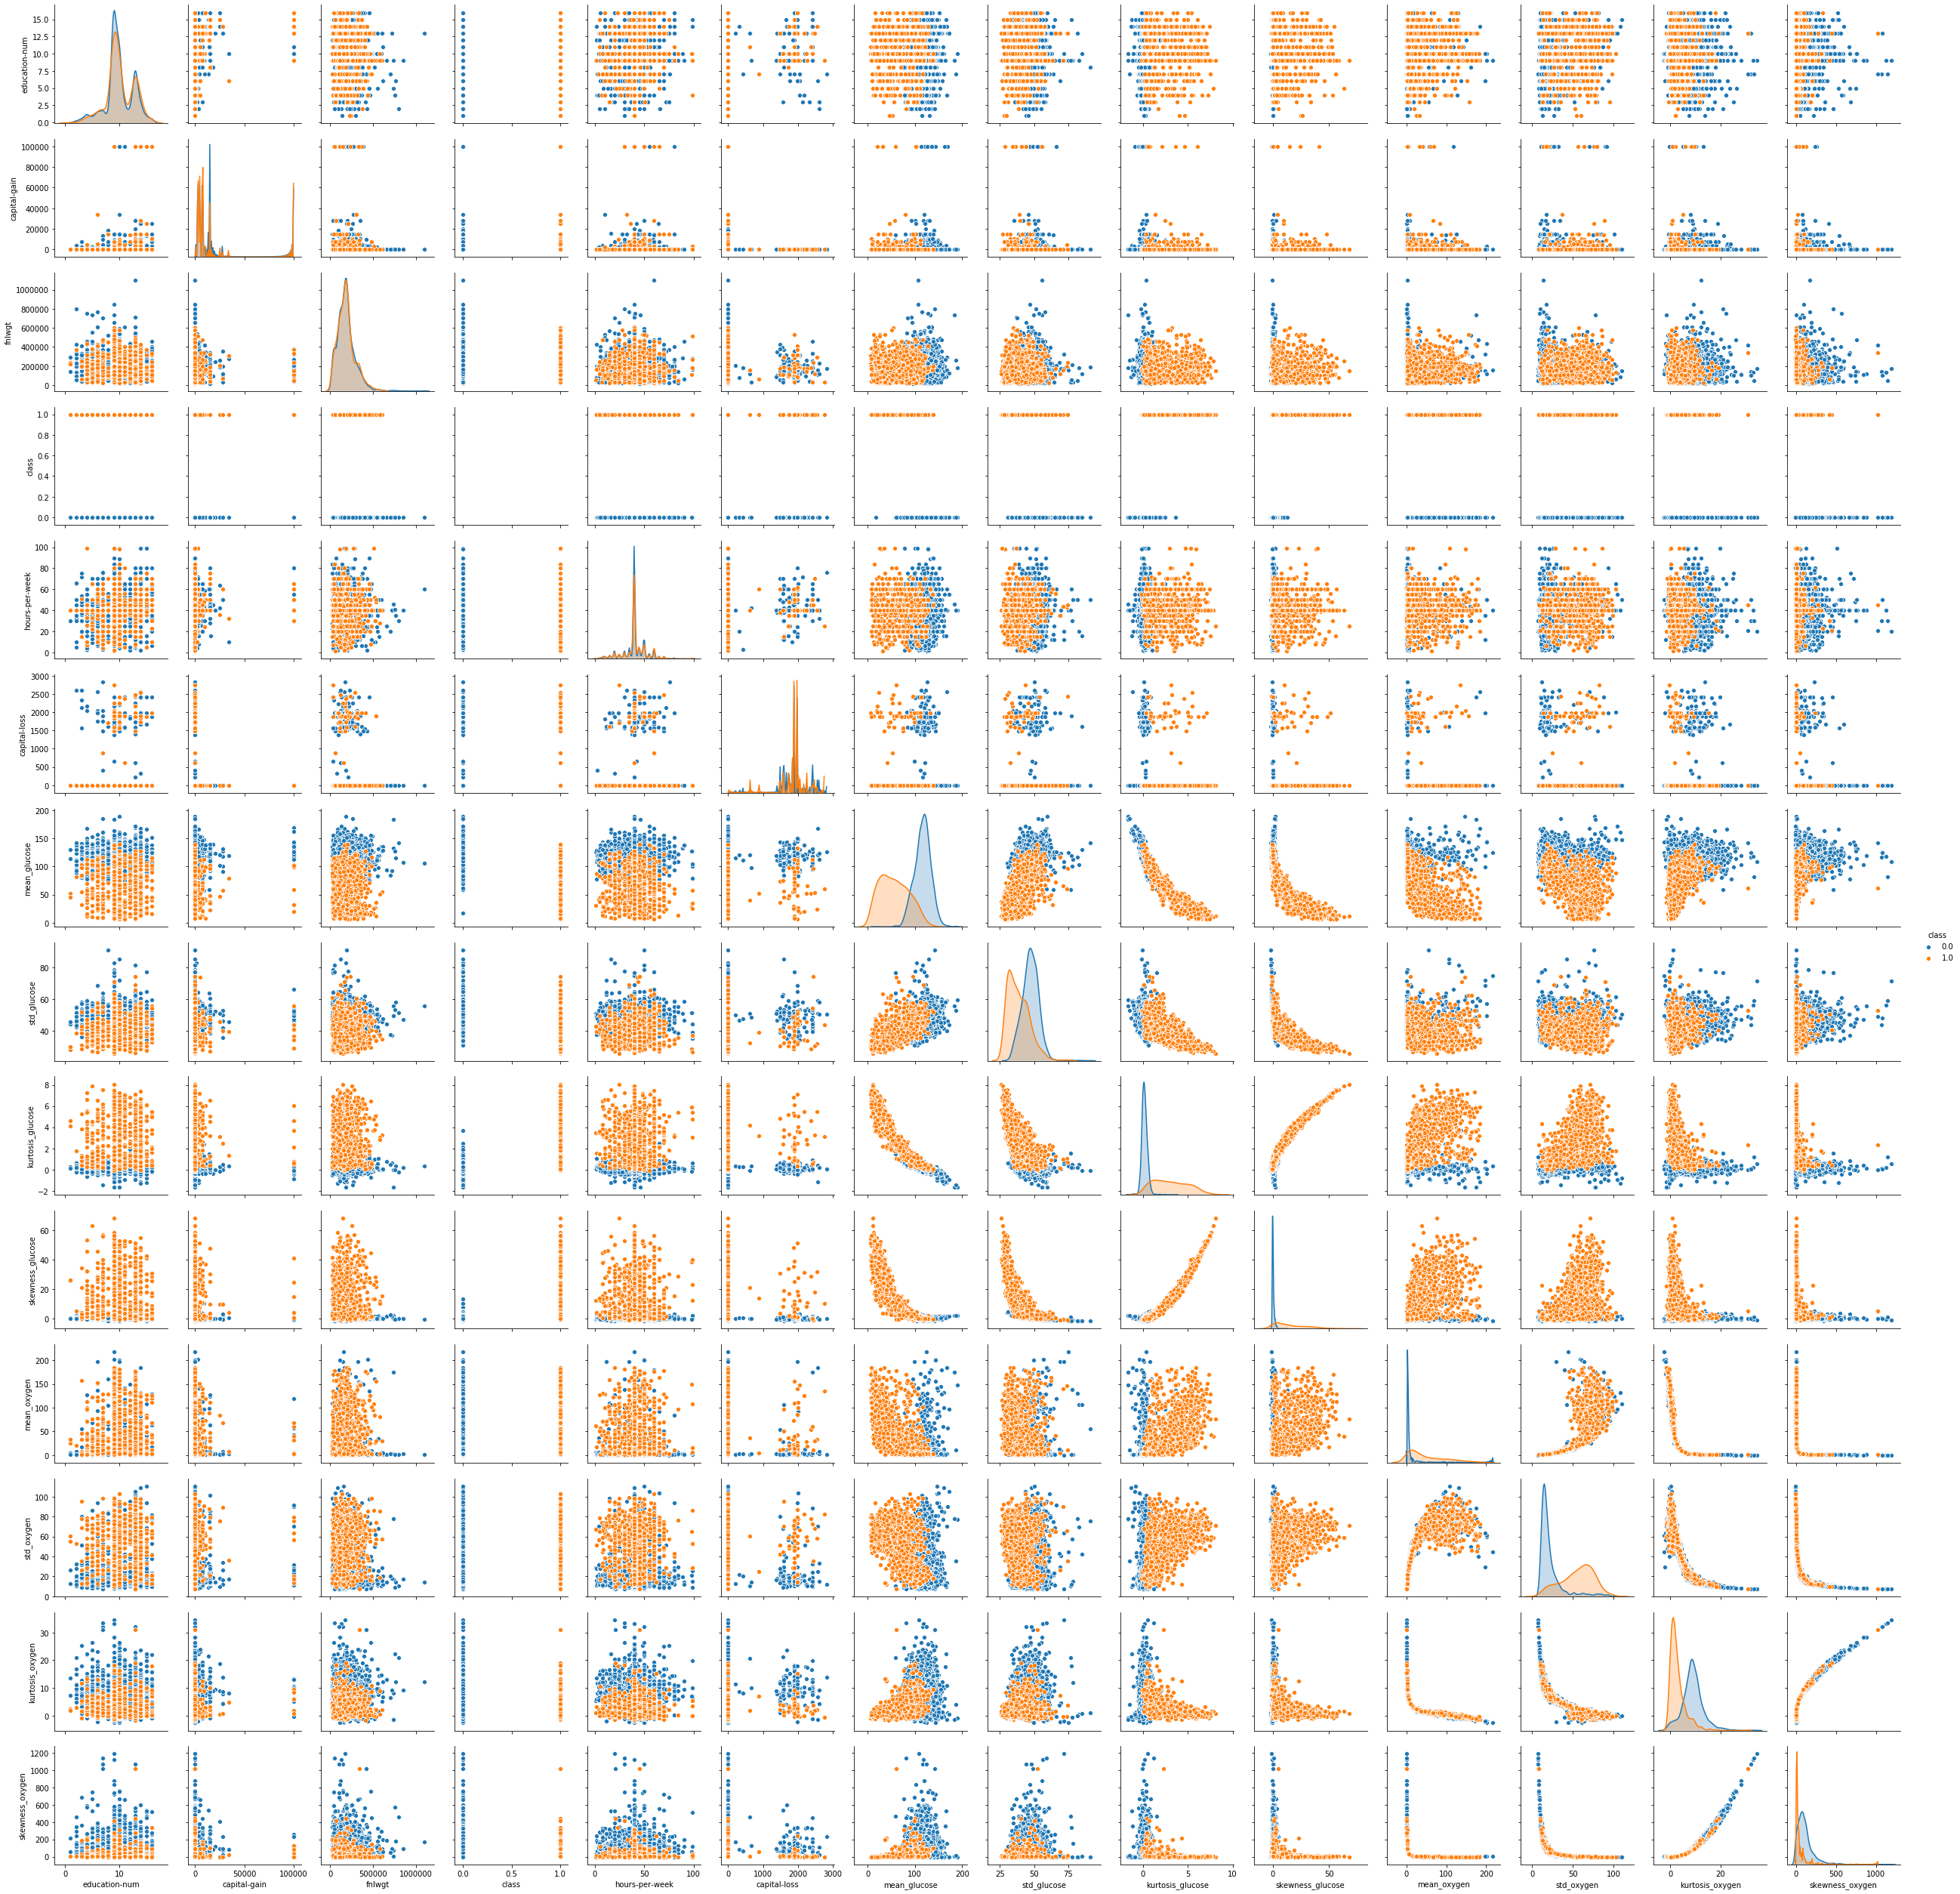

In [96]:
sns.pairplot(og, hue="class")

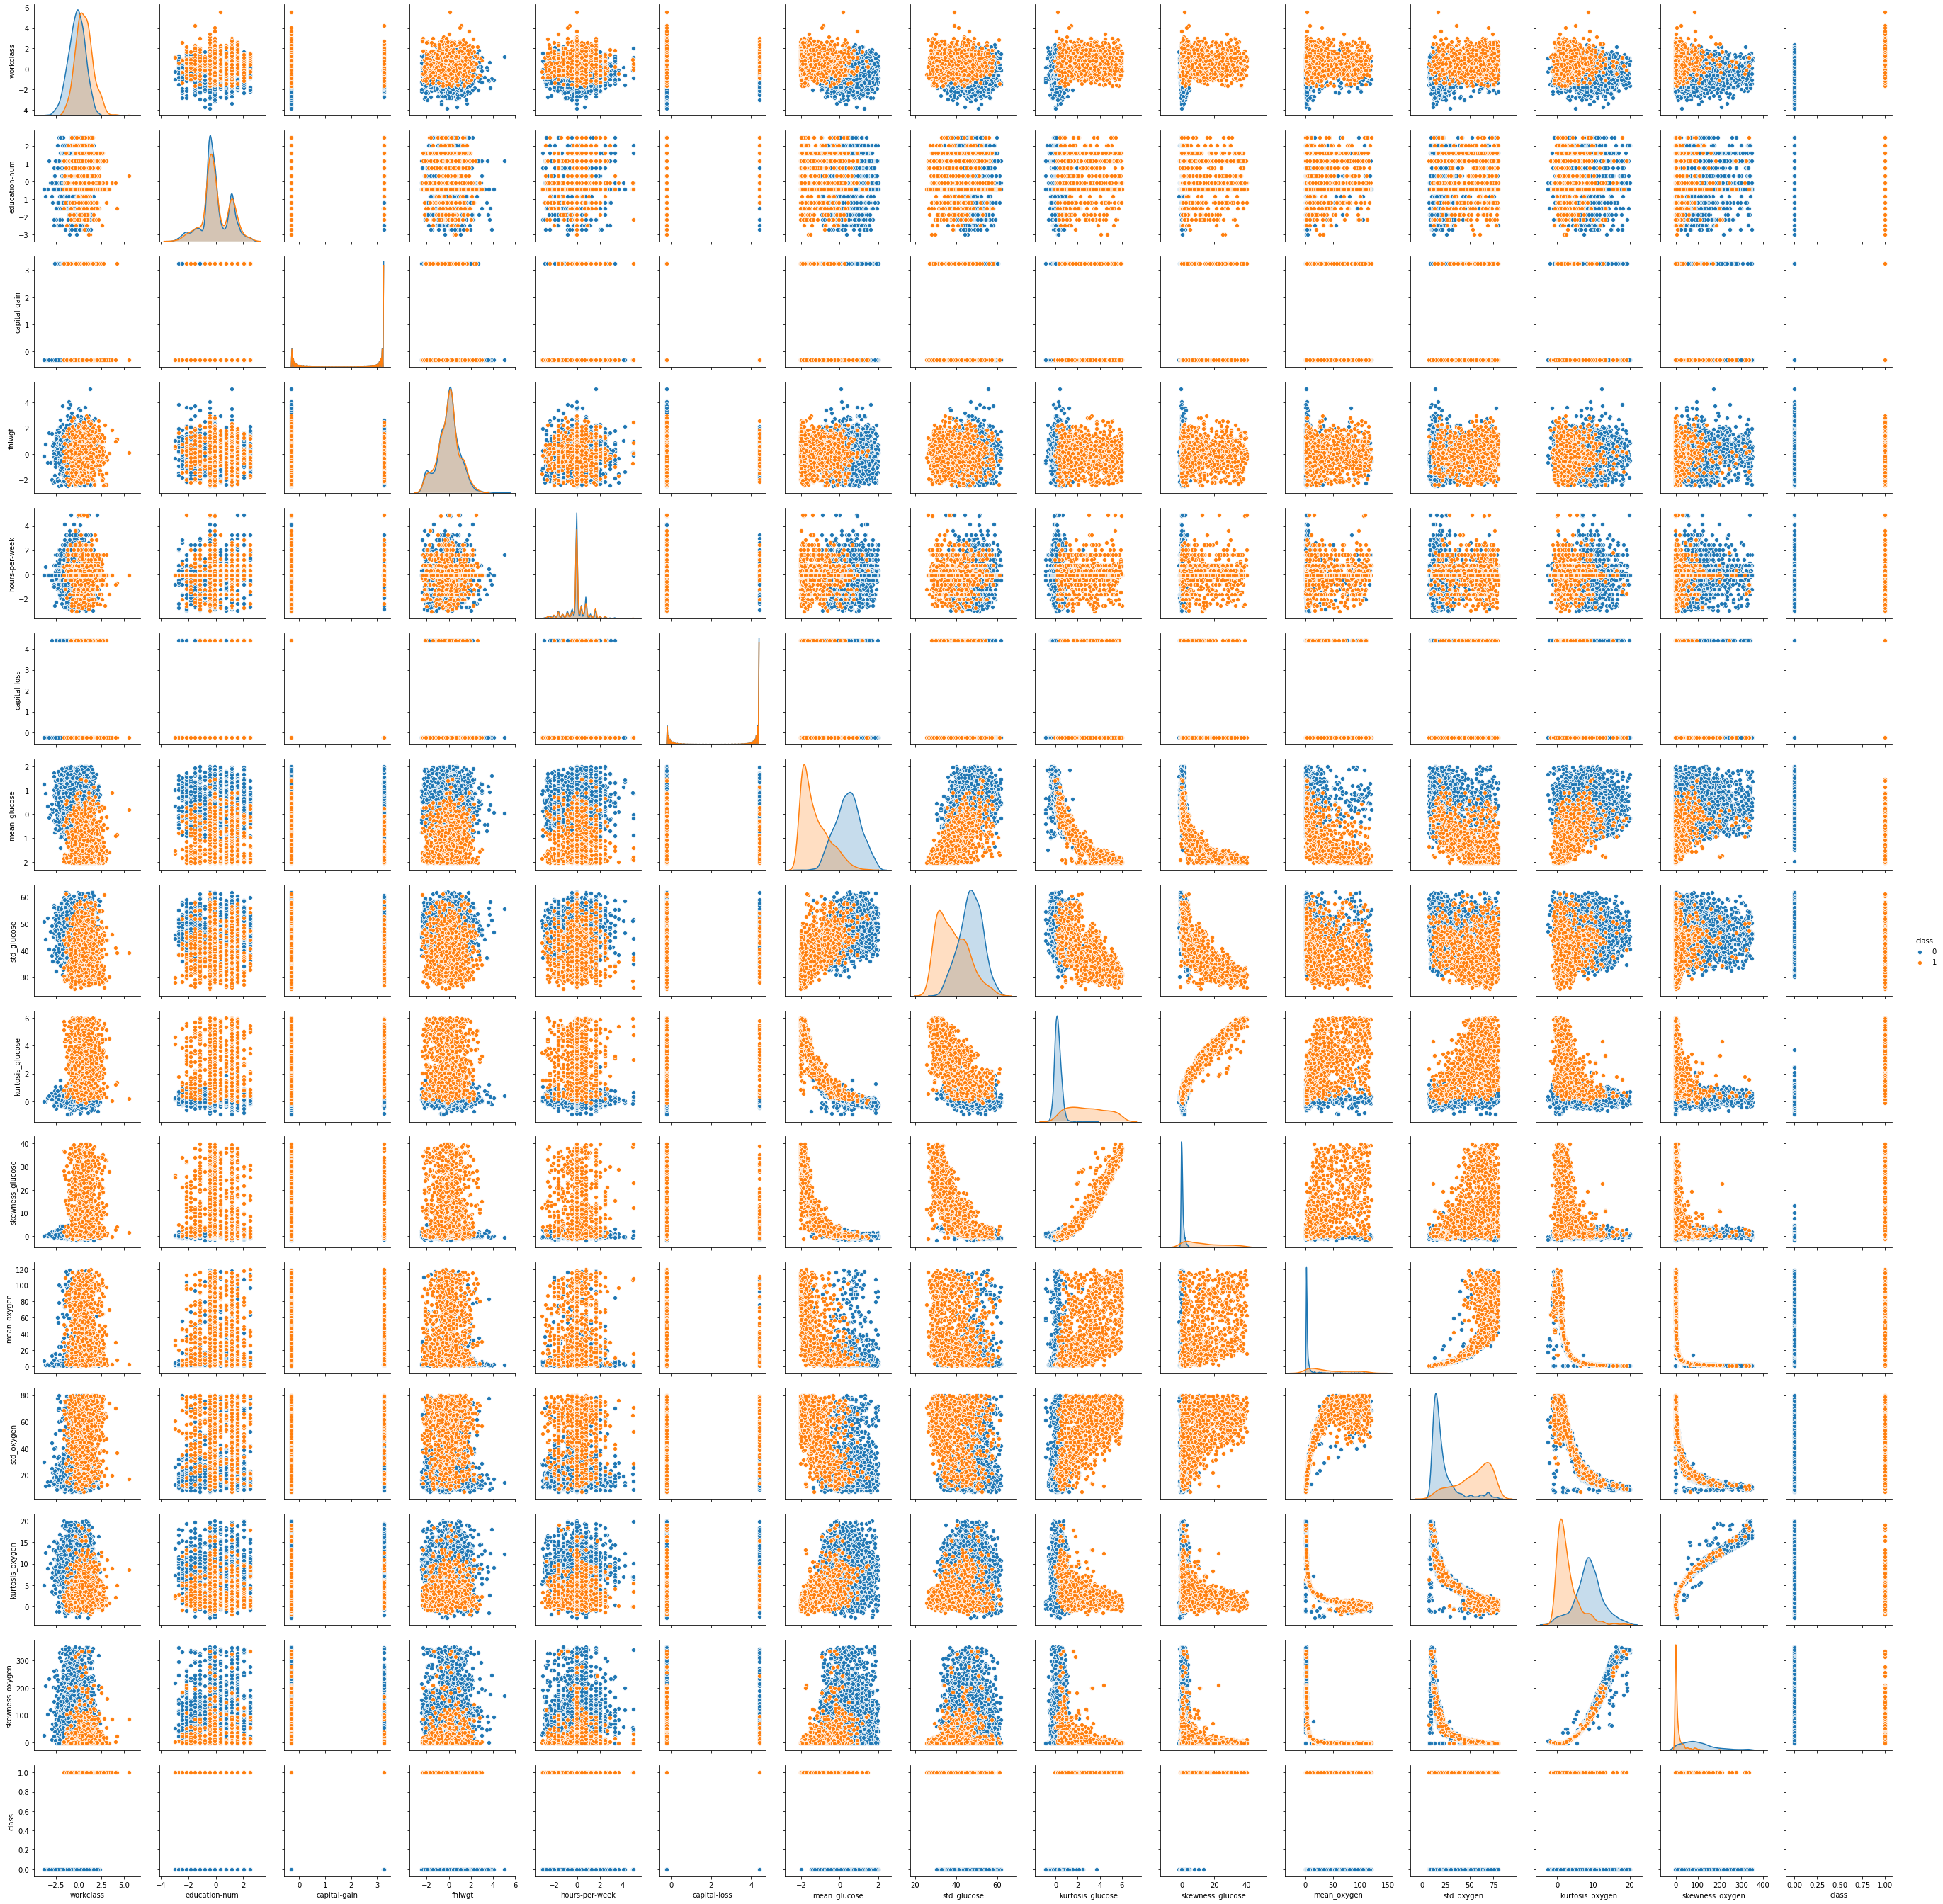

In [56]:
sns.pairplot(merged_data, hue="class")

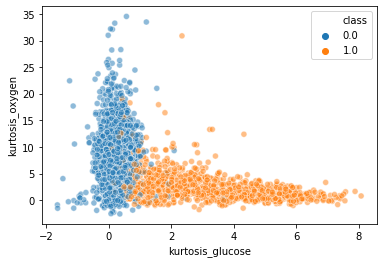

In [97]:
sns.scatterplot(x=og['kurtosis_glucose'], y=og['kurtosis_oxygen'], hue=og['class'], alpha=0.5)

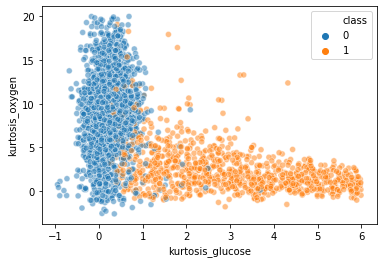

In [51]:
sns.scatterplot(x=merged_data['kurtosis_glucose'], y=merged_data['kurtosis_oxygen'], hue=merged_data['class'], alpha=0.5)

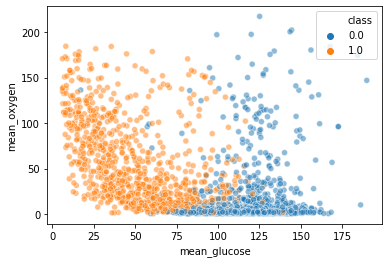

In [98]:
sns.scatterplot(x=og['mean_glucose'], y=og['mean_oxygen'], hue=og['class'], alpha=0.5)

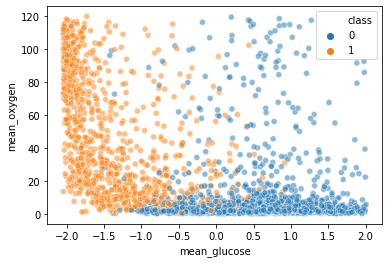

In [52]:
sns.scatterplot(x=merged_data['mean_glucose'], y=merged_data['mean_oxygen'], hue=merged_data['class'], alpha=0.5)

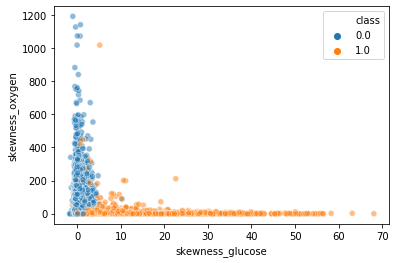

In [99]:
sns.scatterplot(x=og['skewness_glucose'], y=og['skewness_oxygen'], hue=og['class'], alpha=0.5)

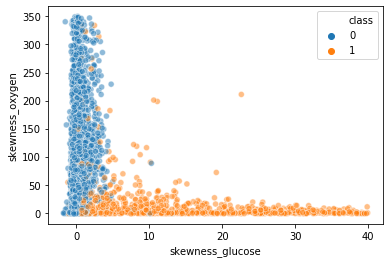

In [53]:
sns.scatterplot(x=merged_data['skewness_glucose'], y=merged_data['skewness_oxygen'], hue=merged_data['class'], alpha=0.5)

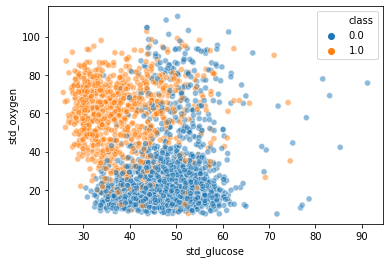

In [100]:
sns.scatterplot(x=og['std_glucose'], y=og['std_oxygen'], hue=og['class'], alpha=0.5)

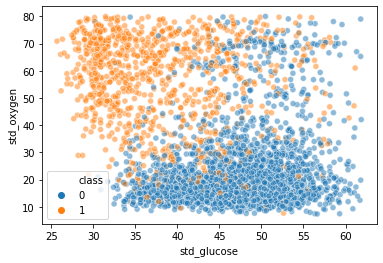

In [54]:
sns.scatterplot(x=merged_data['std_glucose'], y=merged_data['std_oxygen'], hue=merged_data['class'], alpha=0.5)

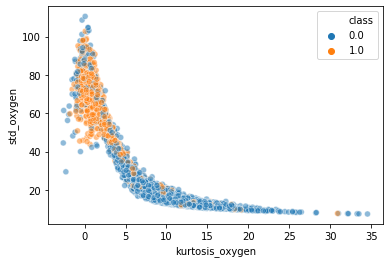

In [101]:
sns.scatterplot(x=og['kurtosis_oxygen'], y=og['std_oxygen'], hue=og['class'], alpha=0.5)

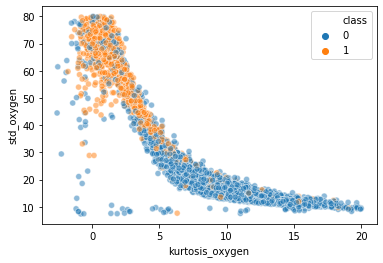

In [55]:
sns.scatterplot(x=merged_data['kurtosis_oxygen'], y=merged_data['std_oxygen'], hue=merged_data['class'], alpha=0.5)

In [102]:
og.corr()

education-num  capital-gain    fnlwgt     class  \
education-num          1.000000      0.110283 -0.038536  0.028786   
capital-gain           0.110283      1.000000 -0.007573 -0.001124   
fnlwgt                -0.038536     -0.007573  1.000000 -0.000473   
class                  0.028786     -0.001124 -0.000473  1.000000   
hours-per-week         0.133849      0.070410 -0.010225  0.013983   
capital-loss           0.063210     -0.033332 -0.012334 -0.000307   
mean_glucose          -0.038715      0.026317  0.013848 -0.774367   
std_glucose           -0.015957      0.011202 -0.005535 -0.501100   
kurtosis_glucose       0.027072     -0.015611 -0.012713  0.788753   
skewness_glucose       0.021361     -0.009300 -0.010573  0.681605   
mean_oxygen            0.042388      0.002081  0.005981  0.516300   
std_oxygen             0.051895      0.015673 -0.010718  0.647597   
kurtosis_oxygen       -0.042016     -0.013817  0.021251 -0.556677   
skewness_oxygen       -0.032651     -0.012664  0.024841 -0.391574   

                  hours-per-week  capital-loss  mean_glucose  std_glucose  \
education-num           0.133849      0.063210     -0.038715    -0.015957   
capital-gain            0.070410     -0.033332      0.026317     0.011202   
fnlwgt                 -0.010225     -0.012334      0.013848    -0.005535   
class                   0.013983     -0.000307     -0.774367    -0.501100   
hours-per-week          1.000000      0.062656     -0.002335    -0.009164   
capital-loss            0.062656      1.000000      0.012267     0.030470   
mean_glucose           -0.002335      0.012267      1.000000     0.646285   
std_glucose            -0.009164      0.030470      0.646285     1.000000   
kurtosis_glucose        0.011410     -0.010456     -0.926026    -0.654050   
skewness_glucose        0.016535     -0.013239     -0.826969    -0.666850   
mean_oxygen             0.026608      0.006396     -0.541593    -0.201644   
std_oxygen              0.011922      0.000065     -0.558425    -0.274788   
kurtosis_oxygen        -0.006118      0.012646      0.472281     0.243290   
skewness_oxygen         0.000697      0.012668      0.307184     0.185004   

                  kurtosis_glucose  skewness_glucose  mean_oxygen  std_oxygen  \
education-num             0.027072          0.021361     0.042388    0.051895   
capital-gain             -0.015611         -0.009300     0.002081    0.015673   
fnlwgt                   -0.012713         -0.010573     0.005981   -0.010718   
class                     0.788753          0.681605     0.516300    0.647597   
hours-per-week            0.011410          0.016535     0.026608    0.011922   
capital-loss             -0.010456         -0.013239     0.006396    0.000065   
mean_glucose             -0.926026         -0.826969    -0.541593   -0.558425   
std_glucose              -0.654050         -0.666850    -0.201644   -0.274788   
kurtosis_glucose          1.000000          0.962181     0.593821    0.618664   
skewness_glucose          0.962181          1.000000     0.550107    0.557176   
mean_oxygen               0.593821          0.550107     1.000000    0.801294   
std_oxygen                0.618664          0.557176     0.801294    1.000000   
kurtosis_oxygen          -0.528521         -0.477987    -0.661197   -0.843372   
skewness_oxygen          -0.346804         -0.312147    -0.397102   -0.605694   

                  kurtosis_oxygen  skewness_oxygen  
education-num           -0.042016        -0.032651  
capital-gain            -0.013817        -0.012664  
fnlwgt                   0.021251         0.024841  
class                   -0.556677        -0.391574  
hours-per-week          -0.006118         0.000697  
capital-loss             0.012646         0.012668  
mean_glucose             0.472281         0.307184  
std_glucose              0.243290         0.185004  
kurtosis_glucose        -0.528521        -0.346804  
skewness_glucose        -0.477987        -0.312147  
mean_oxygen             -0.

In [30]:
merged_data.corr()

education-num  capital-gain    fnlwgt  hours-per-week  \
education-num          1.000000      0.128266 -0.029427        0.137107   
capital-gain           0.128266      1.000000 -0.026326        0.078391   
fnlwgt                -0.029427     -0.026326  1.000000       -0.012071   
hours-per-week         0.137107      0.078391 -0.012071        1.000000   
capital-loss           0.067128     -0.069768 -0.005791        0.051559   
mean_glucose          -0.043972     -0.000417  0.003838        0.001910   
std_glucose           -0.020247      0.005057 -0.001305       -0.009054   
kurtosis_glucose       0.031144     -0.001159 -0.016939        0.010849   
skewness_glucose       0.027031      0.002176 -0.015198        0.018757   
mean_oxygen            0.048545      0.023034 -0.000330        0.021026   
std_oxygen             0.046618      0.022169 -0.004599        0.006937   
kurtosis_oxygen       -0.033464     -0.011721  0.018009       -0.003178   
skewness_oxygen       -0.020831     -0.006427  0.022440        0.001441   

                  capital-loss  mean_glucose  std_glucose  kurtosis_glucose  \
education-num         0.067128     -0.043972    -0.020247          0.031144   
capital-gain         -0.069768     -0.000417     0.005057         -0.001159   
fnlwgt               -0.005791      0.003838    -0.001305         -0.016939   
hours-per-week        0.051559      0.001910    -0.009054          0.010849   
capital-loss          1.000000      0.010624     0.014277         -0.009126   
mean_glucose          0.010624      1.000000     0.659455         -0.847013   
std_glucose           0.014277      0.659455     1.000000         -0.659722   
kurtosis_glucose     -0.009126     -0.847013    -0.659722          1.000000   
skewness_glucose     -0.013236     -0.751350    -0.689762          0.959100   
mean_oxygen          -0.012145     -0.542959    -0.317074          0.645187   
std_oxygen           -0.008110     -0.564973    -0.345467          0.667613   
kurtosis_oxygen       0.024735      0.458945     0.262401         -0.554996   
skewness_oxygen       0.030482      0.349306     0.203723         -0.426386   

                  skewness_glucose  mean_oxygen  std_oxygen  kurtosis_oxygen  \
education-num             0.027031     0.048545    0.046618        -0.033464   
capital-gain              0.002176     0.023034    0.022169        -0.011721   
fnlwgt                   -0.015198    -0.000330   -0.004599         0.018009   
hours-per-week            0.018757     0.021026    0.006937        -0.003178   
capital-loss             -0.013236    -0.012145   -0.008110         0.024735   
mean_glucose             -0.751350    -0.542959   -0.564973         0.458945   
std_glucose              -0.689762    -0.317074   -0.345467         0.262401   
kurtosis_glucose          0.959100     0.645187    0.667613        -0.554996   
skewness_glucose          1.000000     0.605250    0.608113        -0.506425   
mean_oxygen               0.605250     1.000000    0.841879        -0.718767   
std_oxygen                0.608113     0.841879    1.000000        -0.873092   
kurtosis_oxygen          -0.506425    -0.718767   -0.873092         1.000000   
skewness_oxygen          -0.387863    -0.516701   -0.726805         0.940093   

                  skewness_oxygen  
education-num           -0.020831  
capital-gain            -0.006427  
fnlwgt                   0.022440  
hours-per-week           0.001441  
capital-loss             0.030482  
mean_glucose             0.349306  
std_glucose              0.203723  
kurtosis_glucose        -0.426386  
skewness_glucose        -0.387863  
mean_oxygen             -0.516701  
std_oxygen              -0.726805  
kurtosis_oxygen          0.940093  
skewness_oxygen          1.000000

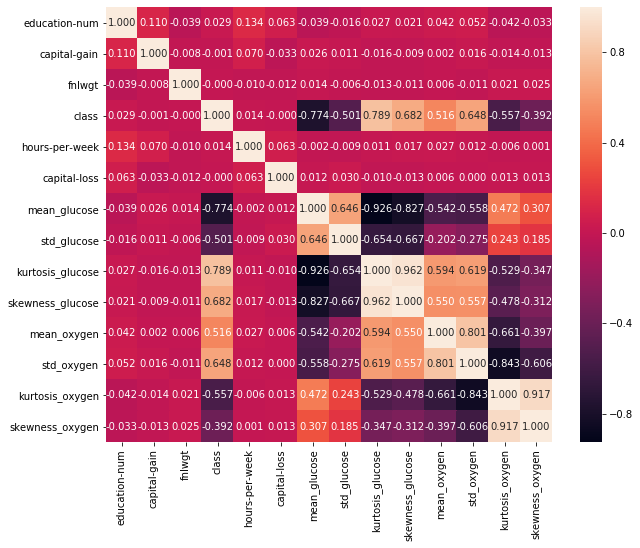

In [103]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(og.corr(), ax=ax, annot=True, fmt=".3f")

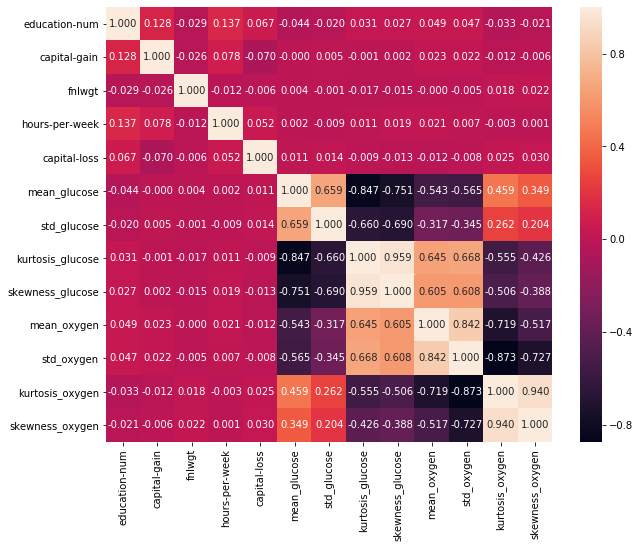

In [31]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(merged_data.corr(), ax=ax, annot=True, fmt=".3f")